# Imports

In [17]:
!pip install -U gensim
import gensim.models.keyedvectors as word2vec #need to use due to depreceated model
#https://www.bigdata-insider.de/was-ist-gensim-a-951758/
from nltk.tokenize import RegexpTokenizer
!pip install keras
!pip install tensorflow
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Conv1D, Dense, Flatten, MaxPooling1D, Dropout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report


import logging

Requirement already up-to-date: gensim in /home/ibrago/anaconda3/lib/python3.7/site-packages (3.8.3)


In [18]:
logging.basicConfig(format='%(asctime)s : %(levelname) s : %(message)s', level=logging.INFO)

#Set random seed
np.random.seed(24)

In [19]:
data = pd.read_csv('https://raw.githubusercontent.com/yaedin/twitter-disaster/main/raw/disaster_tweets.csv')
tweetsData = pd.read_csv('https://raw.githubusercontent.com/yaedin/twitter-disaster/main/raw/disaster_tweets.csv') 
tweetsData.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
#Dividing the dataset into features and lables
tweetsData = tweetsData.rename(columns={"text": "SentimentText", "target": "Sentiment"}, errors="raise")
tweets = tweetsData['SentimentText']
labels = tweetsData['Sentiment']

In [23]:
tweetsData

,id,keyword,location,SentimentText,Sentiment
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


0    4342
1    3271
Name: Sentiment, dtype: int64


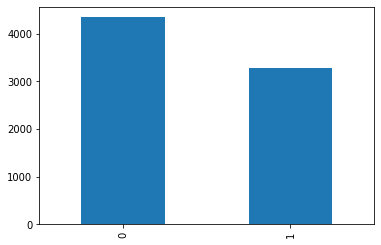

In [24]:
#check the distribution of lebels

labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())

Looks like the distribution is even

In [25]:
#Lower and split the dialog
#and use regular expression to keep only letters we will use nltk Regular expression package
tkr = RegexpTokenizer('[a-zA-Z@]+')

tweets_split = []

for i, line in enumerate(tweets):
    #print(line)
    tweet = str(line).lower().split()
    tweet = tkr.tokenize(str(tweet))
    tweets_split.append(tweet)

print(tweets_split[1])

['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']


In [28]:
w2vModel = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=50000)

2020-10-06 11:30:49,960 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2020-10-06 11:30:50,254 : INFO : loaded (50000, 300) matrix from GoogleNews-vectors-negative300.bin


In [30]:
#Convert words to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_split)
X = tokenizer.texts_to_sequences(tweets_split)

In [32]:
#length of tweet to consider
maxlentweet = 30
#add padding
X = pad_sequences(X, maxlen=maxlentweet)
print(X.shape)

(7613, 30)


In [35]:
#create a embedding layer using Google pre triained word2vec (50000 words)
embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], output_dim=w2vModel.syn0.shape[1], weights=[w2vModel.syn0], input_length=X.shape[1])

/home/ibrago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [36]:
#create model combining LSTM with 1D Convonutional layer and MaxPool layer

lstm_out = 150

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.7))
model.add(LSTM(units=lstm_out))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 300)           15000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 64)            96064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 150)               129000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [37]:
#split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size= 0.1, random_state = 24)

In [38]:
#fit model
batch_size = 32
model.fit(X_train, Y_train, epochs=5, verbose=1, batch_size=batch_size)

Epoch 1/5
215/215 [==============================] - 25s 118ms/step - loss: 0.5938 - accuracy: 0.6760
Epoch 2/5
215/215 [==============================] - 25s 118ms/step - loss: 0.3694 - accuracy: 0.8481
Epoch 3/5
215/215 [==============================] - 25s 119ms/step - loss: 0.2113 - accuracy: 0.9225
Epoch 4/5
215/215 [==============================] - 26s 119ms/step - loss: 0.1149 - accuracy: 0.9616
Epoch 5/5
215/215 [==============================] - 26s 119ms/step - loss: 0.0686 - accuracy: 0.9780


In [39]:
#analyze the results
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size=batch_size)
y_pred = model.predict(X_test)

24/24 - 0s - loss: 0.6516 - accuracy: 0.7927


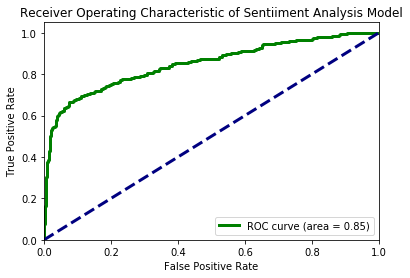

In [40]:
#ROC AUC curve
rocAuc = roc_auc_score(Y_test, y_pred)

falsePositiveRate, truePositiveRate, _ = roc_curve(Y_test, y_pred)

plt.figure()

plt.plot(falsePositiveRate, truePositiveRate, color='green',
         lw=3, label='ROC curve (area = %0.2f)' % rocAuc)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Sentiiment Analysis Model')
plt.legend(loc="lower right")
plt.show()

In [41]:
#Other accuracy metrices
y_pred = (y_pred > 0.5)

#confusion metrix
cm = confusion_matrix(Y_test, y_pred)
print(cm)

#F1 Score, Recall and Precision
print(classification_report(Y_test, y_pred, target_names=['Positive', 'Negative']))

model.save('sentiment_analysis_twitter_cnn_lstm.h5')

#from keras.models import load_model
#
#load_model('sentiment_analysis_twitter_cnn_lstm.h5')

[[376  65]
 [ 93 228]]
              precision    recall  f1-score   support

    Positive       0.80      0.85      0.83       441
    Negative       0.78      0.71      0.74       321

    accuracy                           0.79       762
   macro avg       0.79      0.78      0.78       762
weighted avg       0.79      0.79      0.79       762

